In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        # Read the header
        magic = int.from_bytes(f.read(4), 'big')  # Magic number
        num_images = int.from_bytes(f.read(4), 'big')  # Number of images
        rows = int.from_bytes(f.read(4), 'big')  # Rows per image
        cols = int.from_bytes(f.read(4), 'big')  # Columns per image
        
        # Read the pixel data
        data = f.read()
        images = np.frombuffer(data, dtype=np.uint8)
        images = images.reshape(num_images, rows, cols)  # Shape: (num_images, 28, 28)
        return images

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        # Read the header
        magic = int.from_bytes(f.read(4), 'big')  # Magic number
        num_labels = int.from_bytes(f.read(4), 'big')  # Number of labels
        
        # Read the label data
        data = f.read()
        labels = np.frombuffer(data, dtype=np.uint8)
        return labels

# Example usage
train_images = load_mnist_images(r"D:\Machine Learning Datasets\MNIST\train-images-idx3-ubyte\train-images-idx3-ubyte")
train_labels = load_mnist_labels(r"D:\Machine Learning Datasets\MNIST\train-labels-idx1-ubyte\train-labels-idx1-ubyte")
test_images = load_mnist_images(r"D:\Machine Learning Datasets\MNIST\t10k-images-idx3-ubyte\t10k-images-idx3-ubyte")
test_labels = load_mnist_labels(r"D:\Machine Learning Datasets\MNIST\t10k-labels-idx1-ubyte\t10k-labels-idx1-ubyte")

X_train = train_images.reshape(60000, 784) / 255.0  # Flatten from (60000, 28, 28) to (60000, 784)
X_test = test_images.reshape(10000, 784) / 255.0    # Flatten from (10000, 28, 28) to (10000, 784)
y_train = train_labels
y_test = test_labels

# Verify shapes
print("X_train shape:", X_train.shape)  
print("X_test shape:", X_test.shape)    
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)
y_train shape: (60000,)
y_test shape: (10000,)


# VISUALISING SOME SAMPLE IMAGES

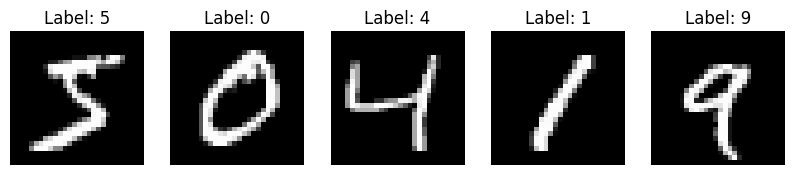

In [3]:
plt.figure(figsize=(10, 2))  # Set figure size
num_samples=5
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)  # 1 row, num_samples columns
    plt.imshow(train_images[i], cmap='gray')  # Display image in grayscale
    plt.title(f"Label: {train_labels[i]}")  # Show the label
    plt.axis('off')  # Hide axes

plt.show()

# PREPARING MODELS:

#### Model_1(Logistic Regression)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Baseline accuracy on clean data
y_pred_clean = model.predict(X_test)
clean_accuracy = accuracy_score(y_test, y_pred_clean)
print(f"Clean Data Accuracy: {clean_accuracy * 100:.2f}%")

Clean Data Accuracy: 92.58%


In [11]:
# FGSM Attack Function
def fgsm_attack(X, y, model, epsilon=0.3):
    X = X.astype(np.float32)
    y = y.astype(np.int32)
    
    # Get model coefficients (weights) for each class
    weights = model.coef_  # Shape: (10, 784) for 10 classes
    intercept = model.intercept_  # Shape: (10,)
    
    # Compute the raw scores (logits) for the input
    scores = X @ weights.T + intercept  # Shape: (10000, 10)
    
    # Gradient of the loss w.r.t. input = difference between true class weights and predicted class weights
    y_pred = np.argmax(scores, axis=1)
    grad = np.zeros_like(X, dtype=np.float32)
    
    for i in range(len(X)):
        if y_pred[i] == y[i]:  # Only perturb if correctly classified
            # Gradient direction: move away from true class
            grad[i] = weights[y[i]]  # Use weights of true class as gradient
    
    # Apply perturbation
    perturbation = epsilon * np.sign(-grad)  # Negative to increase loss
    X_adv = X + perturbation
    # Clip to [0, 1]
    X_adv = np.clip(X_adv, 0, 1)
    return X_adv

# Apply FGSM attack
epsilon = 0.05  # Stronger perturbation
X_test_adv = fgsm_attack(X_test, y_test, model, epsilon)

# Evaluate on adversarial data
y_pred_adv = model.predict(X_test_adv)
adv_accuracy = accuracy_score(y_test, y_pred_adv)
print(f"Adversarial Data Accuracy (ε={epsilon}): {adv_accuracy * 100:.2f}%")

Adversarial Data Accuracy (ε=0.05): 24.55%


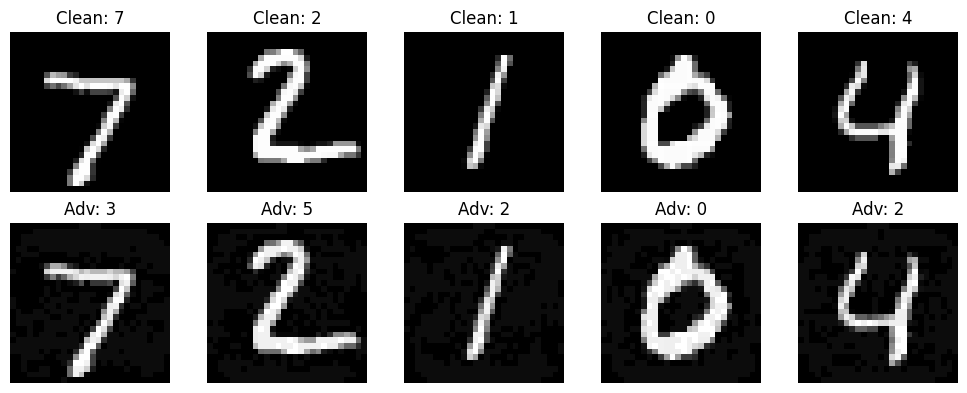

In [12]:

# Visualize clean vs. adversarial examples
num_samples = 5
plt.figure(figsize=(10, 4))
for i in range(num_samples):
    # Clean image
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Clean: {y_pred_clean[i]}")
    plt.axis('off')
    
    # Adversarial image
    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.imshow(X_test_adv[i].reshape(28, 28), cmap='gray')
    plt.title(f"Adv: {y_pred_adv[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

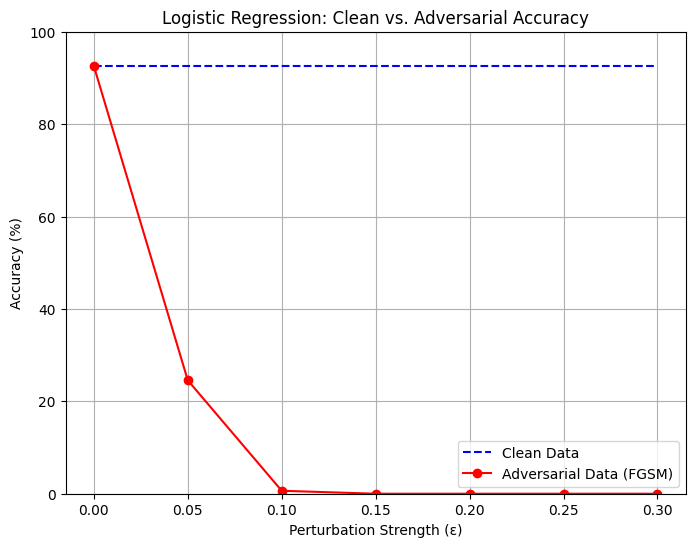

Clean Data Accuracy: 92.58%
Adversarial Data Accuracy (ε=0.05): 24.55%
Adversarial Data Accuracy (ε=0.1): 0.64%
Adversarial Data Accuracy (ε=0.15): 0.00%
Adversarial Data Accuracy (ε=0.2): 0.00%
Adversarial Data Accuracy (ε=0.25): 0.00%
Adversarial Data Accuracy (ε=0.3): 0.00%


In [17]:
epsilon_values = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]  # 0.0 is clean data
clean_accuracy = accuracy_score(y_test, model.predict(X_test)) * 100
adv_accuracies_LgReg = []

for epsilon in epsilon_values[1:]:  # Skip 0.0 since it’s clean
    X_test_adv = fgsm_attack(X_test, y_test, model, epsilon)
    y_pred_adv = model.predict(X_test_adv)
    adv_accuracy = accuracy_score(y_test, y_pred_adv) * 100
    adv_accuracies_LgReg.append(adv_accuracy)

# Add clean accuracy to the list
adv_accuracies_LgReg = [clean_accuracy] + adv_accuracies_LgReg

# Create line graph
plt.figure(figsize=(8, 6))
plt.plot(epsilon_values, [clean_accuracy] * len(epsilon_values), label='Clean Data', color='blue', linestyle='--')
plt.plot(epsilon_values, adv_accuracies_LgReg, label='Adversarial Data (FGSM)', color='red', marker='o')
plt.xlabel('Perturbation Strength (ε)')
plt.ylabel('Accuracy (%)')
plt.title('Logistic Regression: Clean vs. Adversarial Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)  # Set y-axis range from 0 to 100%
plt.show()

# Print accuracies for reference
print(f"Clean Data Accuracy: {clean_accuracy:.2f}%")
for eps, acc in zip(epsilon_values[1:], adv_accuracies[1:]):
    print(f"Adversarial Data Accuracy (ε={eps}): {acc:.2f}%")

# Model_2(Decision Trees)

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
# Train Decision Tree
model = DecisionTreeClassifier(random_state=42, max_depth=20)  # Limit depth to prevent overfitting
model.fit(X_train, y_train)

# Predictions on clean data
y_pred_clean = model.predict(X_test)
clean_accuracy = accuracy_score(y_test, y_pred_clean)
print(f"Clean Data Accuracy (Decision Tree): {clean_accuracy * 100:.2f}%")

Clean Data Accuracy (Decision Tree): 88.18%


In [20]:
# FGSM Attack Function (adapted for Decision Trees)
def fgsm_attack(X, y, model, epsilon=0.1):
    X = X.astype(np.float32)
    y = y.astype(np.int32)
    
    # Approximate gradient by perturbing towards misclassification
    # For Decision Trees, we use the feature importance or random perturbation
    grad = np.zeros_like(X, dtype=np.float32)
    y_pred = model.predict(X)
    for i in range(len(X)):
        if y_pred[i] != y[i]:  # Skip if already misclassified
            continue
        # Simple gradient approximation: perturb in random direction (since trees don't provide gradients directly)
        grad[i] = np.random.uniform(-1, 1, size=X.shape[1])  # Random direction
        # Alternatively, we could use feature importance, but let's start with random
    
    # Apply perturbation
    perturbation = epsilon * np.sign(grad)
    X_adv = X + perturbation
    
    # Clip to [0, 1]
    X_adv = np.clip(X_adv, 0, 1)
    return X_adv

epsilon = 0.1
X_test_adv = fgsm_attack(X_test, y_test, model, epsilon)
y_pred_adv = model.predict(X_test_adv)
adv_accuracy = accuracy_score(y_test, y_pred_adv)
print(f"Adversarial Data Accuracy (ε={epsilon}, Decision Tree): {adv_accuracy * 100:.2f}%")

Adversarial Data Accuracy (ε=0.1, Decision Tree): 31.89%


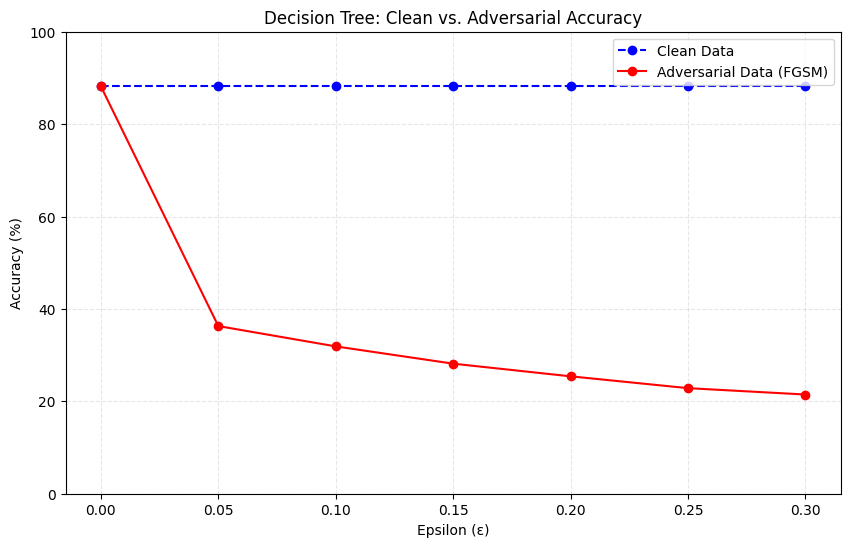

In [22]:
epsilons = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
clean_accuracies = []
adv_accuracies_DT = []

for eps in epsilons:
    # Clean accuracy (constant for all eps)
    clean_accuracies.append(clean_accuracy)
    
    # Adversarial accuracy
    X_test_adv = fgsm_attack(X_test, y_test, model, eps)
    y_pred_adv = model.predict(X_test_adv)
    adv_acc = accuracy_score(y_test, y_pred_adv)
    adv_accuracies_DT.append(adv_acc)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(epsilons, [acc * 100 for acc in clean_accuracies], label='Clean Data', color='blue', linestyle='--', marker='o')
plt.plot(epsilons, [acc * 100 for acc in adv_accuracies_DT], label='Adversarial Data (FGSM)', color='red', linestyle='-', marker='o')

plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy (%)')
plt.title('Decision Tree: Clean vs. Adversarial Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(0, 100)
plt.show()

# MODEL-3 (Random_Forest)

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rf_clean_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Clean Data Accuracy: {rf_clean_accuracy * 100:.2f}%")

Random Forest Clean Data Accuracy: 97.04%


In [28]:
X_test_adv = fgsm_attack(X_test, y_test, rf_model, 0.05)
y_pred_adv_rf = rf_model.predict(X_test_adv)
rf_adv_accuracy = accuracy_score(y_test, y_pred_adv_rf)
print(f"Random Forest Adversarial Data Accuracy (ε=0.05): {rf_adv_accuracy * 100:.2f}%")

Random Forest Adversarial Data Accuracy (ε=0.05): 71.15%


Random Forest Adversarial Data Accuracy (ε=0.0): 97.04%
Random Forest Adversarial Data Accuracy (ε=0.05): 70.85%
Random Forest Adversarial Data Accuracy (ε=0.1): 63.69%
Random Forest Adversarial Data Accuracy (ε=0.15): 59.50%
Random Forest Adversarial Data Accuracy (ε=0.2): 57.01%
Random Forest Adversarial Data Accuracy (ε=0.25): 53.41%
Random Forest Adversarial Data Accuracy (ε=0.3): 50.34%


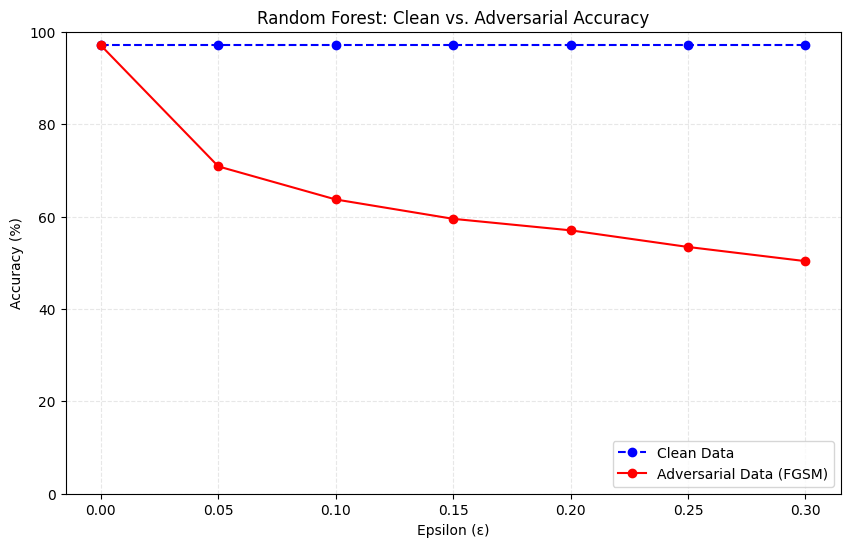

In [29]:
# Define epsilon values (same as your Logistic Regression plot)
epsilons = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
clean_accuracies = []
adv_accuracies_RF = []

# Evaluate across epsilon values
for eps in epsilons:
    # Clean accuracy (constant for all eps)
    clean_accuracies.append(rf_clean_accuracy)  # Use Random Forest clean accuracy
    
    # Adversarial accuracy with FGSM
    X_test_adv = fgsm_attack(X_test, y_test, rf_model, eps)
    y_pred_adv = rf_model.predict(X_test_adv)
    adv_acc = accuracy_score(y_test, y_pred_adv)
    adv_accuracies_RF.append(adv_acc)
    print(f"Random Forest Adversarial Data Accuracy (ε={eps}): {adv_acc * 100:.2f}%")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epsilons, [acc * 100 for acc in clean_accuracies], label='Clean Data', color='blue', linestyle='--', marker='o')
plt.plot(epsilons, [acc * 100 for acc in adv_accuracies_RF], label='Adversarial Data (FGSM)', color='red', linestyle='-', marker='o')

plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy (%)')
plt.title('Random Forest: Clean vs. Adversarial Accuracy')
plt.legend(loc='lower right')  # Place legend inside the plot
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(0, 100)
plt.show()

# Model-4 (Convulational Neural-Network(CNN))

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [36]:
X_train_cnn = train_images.reshape(-1, 28, 28, 1) / 255.0
X_test_cnn = test_images.reshape(-1, 28, 28, 1) / 255.0

num_classes = 10  # MNIST has 10 classes (digits 0-9)
y_train_cnn = to_categorical(train_labels, num_classes)
y_test_cnn = to_categorical(test_labels, num_classes)

In [37]:
# Build the CNN model
cnn_model = Sequential([
    # First convolutional layer with 32 filters, 3x3 kernel and ReLU activation
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Second convolutional layer with 64 filters
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the feature maps before the dense layers
    Flatten(),
    
    # Dense layer with 128 neurons
    Dense(128, activation='relu'),
    Dropout(0.5),  # Adding dropout for regularization
    
    # Output layer with softmax activation for classification
    Dense(num_classes, activation='softmax')
])

# Compile the model using Adam optimizer and categorical crossentropy loss
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
cnn_model.summary()

# Train the model
history = cnn_model.fit(X_train_cnn, y_train_cnn, batch_size=128, epochs=10, validation_data=(X_test_cnn, y_test_cnn))

# Evaluate the model on the test data
score = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7980 - loss: 0.6416 - val_accuracy: 0.9797 - val_loss: 0.0649
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9676 - loss: 0.1076 - val_accuracy: 0.9853 - val_loss: 0.0434
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9772 - loss: 0.0780 - val_accuracy: 0.9878 - val_loss: 0.0368
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9818 - loss: 0.0609 - val_accuracy: 0.9902 - val_loss: 0.0312
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9850 - loss: 0.0525 - val_accuracy: 0.9914 - val_loss: 0.0266
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9871 - loss: 0.0425 - val_accuracy: 0.9912 - val_loss: 0.0268
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9889 - loss: 0.0358 - val_accuracy: 0.9914 - val_loss: 0.0266
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9898 - loss: 0.0339 - val_accu

In [38]:
def create_adversarial_pattern(model, input_image, input_label):
    # Ensure input_image and input_label are tensors
    input_image = tf.convert_to_tensor(input_image)
    input_label = tf.convert_to_tensor(input_label)
    
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.categorical_crossentropy(input_label, prediction)
    
    # Get the gradients of the loss w.r.t. the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

In [39]:
def generate_adversarial_examples(model, X, y, epsilon):
    adv_examples = []
    for i in range(len(X)):
        x = X[i:i+1]  # select one image
        y_true = y[i:i+1]  # corresponding one-hot label
        perturbations = create_adversarial_pattern(model, x, y_true)
        adv_x = x + epsilon * perturbations
        # Clip the values to keep them in [0,1]
        adv_x = tf.clip_by_value(adv_x, 0, 1)
        adv_examples.append(adv_x.numpy())
    return np.vstack(adv_examples)

# Choose an epsilon value (e.g., 0.1)
epsilon = 0.3
X_test_adv = generate_adversarial_examples(cnn_model, X_test_cnn, y_test_cnn, epsilon)

score_adv = cnn_model.evaluate(X_test_adv, y_test_cnn, verbose=0)
print("Test loss on adversarial examples:", score_adv[0])
print("Test accuracy on adversarial examples:", score_adv[1])

Test loss on adversarial examples: 3.2224628925323486
Test accuracy on adversarial examples: 0.25850000977516174


In [40]:
epsilons = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
adv_accuracy=[]
for i in epsilons:
    x_test_adv = generate_adversarial_examples(cnn_model, X_test_cnn, y_test_cnn, i)

    score_adv = cnn_model.evaluate(x_test_adv, y_test_cnn, verbose=0)
    print(f"Accuracy for eps({i}): ",score_adv[1])
    adv_accuracy.append(score_adv[1])

Accuracy for eps(0.0):  0.9921000003814697
Accuracy for eps(0.05):  0.9667999744415283
Accuracy for eps(0.1):  0.9000999927520752
Accuracy for eps(0.15):  0.7623999714851379
Accuracy for eps(0.2):  0.5605000257492065
Accuracy for eps(0.25):  0.37380000948905945
Accuracy for eps(0.3):  0.25850000977516174


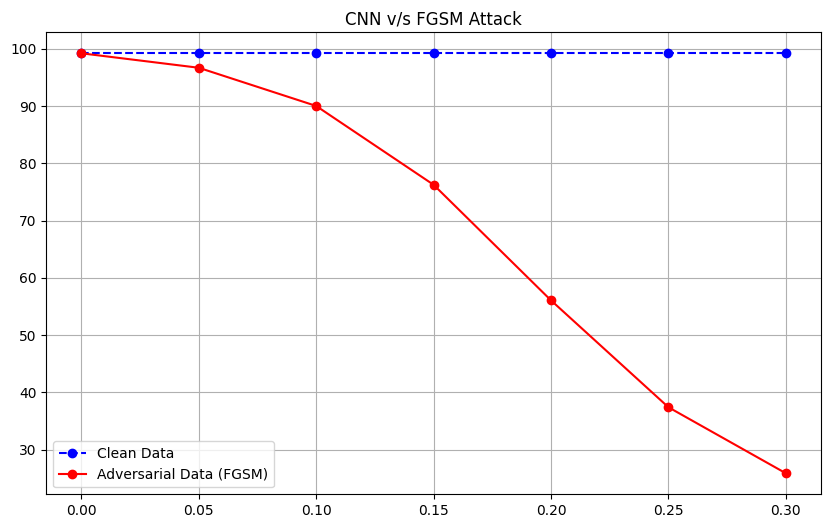

In [41]:
adv_CNN = np.array(adv_accuracy)
clean = []
for i in range(len(adv_CNN)):
    adv_CNN[i] = round(adv_CNN[i]*100,2)
    clean.append(adv_CNN[0])
plt.figure(figsize=(10,6))
plt.plot(epsilons,clean,label='Clean Data', color='blue', linestyle='--', marker='o')
plt.plot(epsilons,adv_CNN, label='Adversarial Data (FGSM)', color='red', linestyle='-', marker='o')
plt.xticks(epsilons)
plt.title('CNN v/s FGSM Attack')
plt.grid(True)
plt.legend()
plt.show()

# Model-5 (K Nearest-Neighbor)

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [45]:
knn_model = KNeighborsClassifier(n_neighbors=3)  # Using 5 neighbors as a default
knn_model.fit(X_train, y_train)

# Baseline accuracy on clean data
y_pred_clean = knn_model.predict(X_test)
clean_accuracy = accuracy_score(y_test, y_pred_clean)
print(f"KNN Clean Data Accuracy: {clean_accuracy * 100:.2f}%")

KNN Clean Data Accuracy: 97.05%


In [46]:
def fgsm_attack_knn(X, y, model, epsilon, X_train, y_train):
    """
    Generate adversarial examples using the Fast Gradient Sign Method (FGSM) for KNN.
    Since KNN is non-differentiable, we approximate the gradient using a surrogate model or a simple heuristic.
    Here, we use a heuristic: perturb the input in the direction that increases the distance to the nearest neighbors
    of the correct class.
    """
    X_adv = X.copy()
    n_samples = X.shape[0]
    
    for i in range(n_samples):
        # Get the current sample and its true label
        x = X[i].reshape(1, -1)
        true_label = y[i]
        
        # Find the nearest neighbors and their labels
        distances, indices = model.kneighbors(x, n_neighbors=5)
        neighbor_labels = y_train[indices[0]]
        
        # Approximate the "gradient" by moving away from the correct class neighbors
        # We compute the average direction towards neighbors of the wrong class
        wrong_class_indices = indices[0][neighbor_labels != true_label]
        if len(wrong_class_indices) > 0:
            # Average the direction towards wrong-class neighbors
            wrong_class_neighbors = X_train[wrong_class_indices]
            direction = np.mean(wrong_class_neighbors - x, axis=0)
            direction = np.sign(direction)  # Take the sign of the direction (FGSM)
            # Apply perturbation
            X_adv[i] += epsilon * direction
        # Clip the adversarial example to ensure it stays within valid pixel range [0, 1]
        X_adv[i] = np.clip(X_adv[i], 0, 1)
    
    return X_adv

KNN Adversarial Data Accuracy (ε=0.0): 97.05%
KNN Adversarial Data Accuracy (ε=0.05): 95.51%
KNN Adversarial Data Accuracy (ε=0.1): 94.25%
KNN Adversarial Data Accuracy (ε=0.15): 93.21%
KNN Adversarial Data Accuracy (ε=0.2): 92.43%
KNN Adversarial Data Accuracy (ε=0.25): 91.83%
KNN Adversarial Data Accuracy (ε=0.3): 91.31%


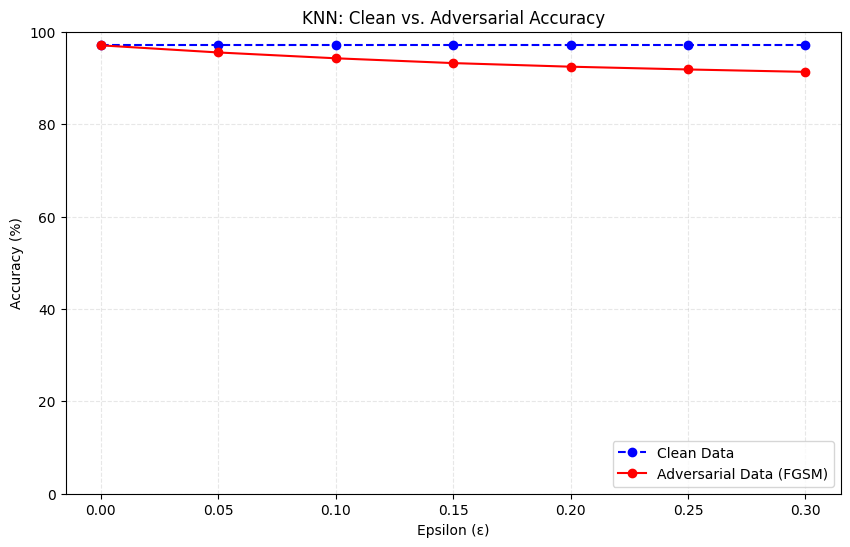

In [47]:
# Define epsilon values
epsilons = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
clean_accuracies = []
adv_accuracies_KNN = []

# Evaluate across epsilon values
for eps in epsilons:
    # Clean accuracy (constant for all eps)
    clean_accuracies.append(clean_accuracy)
    
    # Adversarial accuracy with FGSM
    X_test_adv = fgsm_attack_knn(X_test, y_test, knn_model, eps, X_train, y_train)
    y_pred_adv = knn_model.predict(X_test_adv)
    adv_acc = accuracy_score(y_test, y_pred_adv)
    adv_accuracies_KNN.append(adv_acc)
    print(f"KNN Adversarial Data Accuracy (ε={eps}): {adv_acc * 100:.2f}%")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epsilons, [acc * 100 for acc in clean_accuracies], label='Clean Data', color='blue', linestyle='--', marker='o')
plt.plot(epsilons, [acc * 100 for acc in adv_accuracies_KNN], label='Adversarial Data (FGSM)', color='red', linestyle='-', marker='o')

plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy (%)')
plt.title('KNN: Clean vs. Adversarial Accuracy')
plt.legend(loc='lower right')  # Place legend inside the plot
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(0, 100)
plt.show()

# Comparison

In [70]:
import seaborn as sns
import pandas as pd
sns.set()

In [113]:
data = pd.DataFrame({
    "eps":epsilons,
    "Logistic-Regression": adv_accuracies_LgReg,
    "Decision-Trees": adv_accuracies_DT,
    "Random-Forest": adv_accuracies_RF,
    "Con Neural-Network": adv_CNN,
    "k Nearest-Nbr": adv_accuracies_KNN
})
cols = ['Decision-Trees','Random-Forest','k Nearest-Nbr']
data[cols] = data[cols]*100
data.set_index(data['eps'],inplace=True)
data.drop(columns=['eps'],inplace=True)
data

,Logistic-Regression,Decision-Trees,Random-Forest,Con Neural-Network,k Nearest-Nbr
eps,,,,,
0.00,92.58,88.18,97.04,99.21,97.05
0.05,24.55,36.29,70.85,96.68,95.51
0.10,0.64,31.89,63.69,90.01,94.25
0.15,0.00,28.15,59.50,76.24,93.21
0.20,0.00,25.41,57.01,56.05,92.43
0.25,0.00,22.85,53.41,37.38,91.83
0.30,0.00,21.47,50.34,25.85,91.31


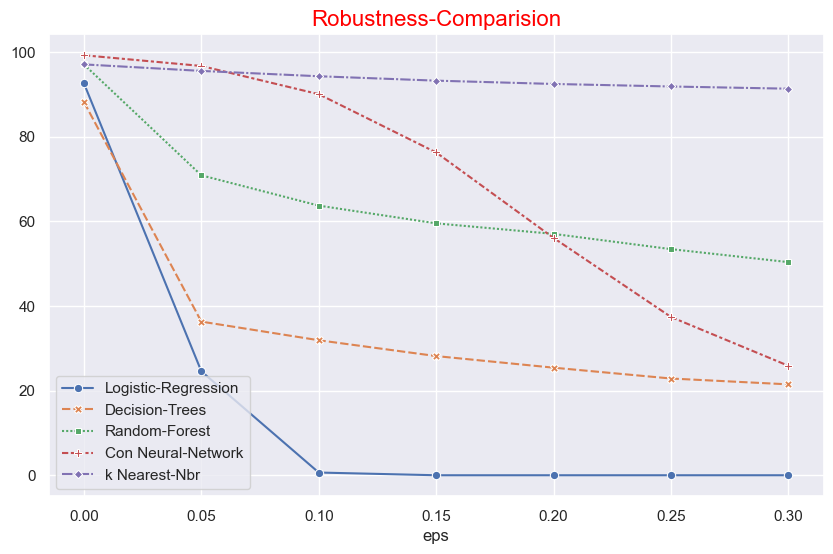

In [127]:
plt.figure(figsize=(10,6))
sns.lineplot(data=data,markers=True);plt.title('Robustness-Comparision',fontdict={'fontsize':16,'color':'red'})
plt.show()